<a href="https://colab.research.google.com/github/DCDPUAEM/DCDP_2022/blob/main/03-Deep-Learning/notebooks/04-Herramientas-Adicionales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Herramientas Adicionales</h1>

El objetivo de esta notebook es mostrar algunas herramientas adicionales para mejorar el entrenamiento y/o desempeño de redes neuronales. En particular, veremos:

* Callbacks
    * Early Stopping
    * Checkpoint
* Dropout
* Gridsearch

Además, realizaremos ejemplos de clasificación binaria.

Verificar que tenemos una GPU:

In [ ]:
import tensorflow as tf

print('GPU presente en: {}'.format(tf.test.gpu_device_name()))

# Callbacks

Un *callback* es un objeto que puede realizar acciones en varias etapas del entrenamiento (por ejemplo, al inicio o al final de una época, antes o después de un *batch*, etc.).

Puedes usar *callbacks* para:

* Escribir los registros de TensorBoard después de cada lote de entrenamiento para monitorizar tus métricas
* Guardar periódicamente tu modelo en el disco
* Hacer un *early stopping*.
* Obtener una visión de los estados internos y las estadísticas de un modelo durante el entrenamiento.

Podemos consultar la lista completa de callbacks en https://keras.io/api/callbacks/

Para ilustrar algunos callbacks, consideremos el siguiente ejemplo ilustrativo. Entrenaremos una red neuronal MLP para clasificar el siguiente dataset.

In [ ]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

X, y = make_moons(n_samples=400, noise=0.21, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X,y,train_size=0.8,random_state=199)

plt.figure()
plt.scatter(X_train[:,0],X_train[:,1],c=y_train)
plt.show()

## Callbacks: `EarlyStopping`

El [`EarlyStopping`](https://keras.io/api/callbacks/early_stopping/) es un *callback* que nos permite detener el entrenamiento para evitar el overfitting. El callback monitorea el entrenamiento y lo detiene en el momento en el que una métrica (o perdida) deja de mejorar.

Algunos de los principales hiperparámetros son:

* `monitor`: Cantidad a controlar.
* `min_delta`: Cambio mínimo en la cantidad monitorizada para calificar como mejora, es decir, un cambio absoluto inferior a min_delta, contará como no mejora.
* `patience`: Número de épocas sin mejora tras las cuales se detendrá el entrenamiento.
* `mode`: Puede ser {"auto", "min", "max"}. En el modo "min", el entrenamiento se detendrá cuando la cantidad supervisada haya dejado de disminuir; en el modo "max", se detendrá cuando la cantidad supervisada haya dejado de aumentar; en el modo "auto", la dirección se deduce automáticamente del nombre de la cantidad o métrica supervisada.

Definimos y entrenamos una red neuronal. Observa el número de neuronas en la capa de salida y la función de activación.

Su desempeño tendrá un accuracy mucho menor en el conjunto de prueba. Observa las curvas de aprendizaje, **es un caso claro de overfitting**.

*El tiempo de ejecución es de alrededor de 2 minutos*

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

#----- Definimos el modelo -------
model = Sequential()
model.add(Dense(500, input_dim=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#----- Entremamos el modelo ------
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1800, verbose=0)

In [ ]:
# evaluamos el modelo
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, val_acc = model.evaluate(X_val, y_val, verbose=0)
print('Train accuracy: %.3f. Validation accuracy : %.3f' % (train_acc, val_acc))

# ---- graficamos la función de perdida ----
plt.figure(figsize=(11,5))
plt.subplot(1,2,1)
plt.suptitle("Validation and Training Loss",fontsize=14)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
# ---- graficamos la métrica de rendimiento ----
plt.subplot(1,2,2)
plt.suptitle("Validation and Training Accuracy",fontsize=14)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

Ahora, usemos el callback

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping


model = Sequential()
model.add(Dense(500, input_dim=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Definimos el *callback*. Es una clase por lo que tenemos que inicializarla con hiperparámetros y obtenemos un objeto.

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

Entrenamos usando el *callback*. Observa en cuántas épocas detiene el entrenamiento.

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=2000, verbose=0,
                    callbacks=[es])


_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, val_acc = model.evaluate(X_val, y_val, verbose=0)
print('Train accuracy: %.3f. Validation accuracy : %.3f' % (train_acc, val_acc))

Graficamos el entrenamiento

In [ ]:
# ---- graficamos la función de perdida ----
plt.figure(figsize=(11,5))
plt.subplot(1,2,1)
plt.suptitle("Validation and Training Loss",fontsize=14)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
# ---- graficamos la métrica de rendimiento ----
plt.subplot(1,2,2)
plt.suptitle("Validation and Training Accuracy",fontsize=14)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

## Callbacks: `ModelCheckpoint`

Este callback sirve para guardar el modelo en el momento en que comenzó el overfitting y se comenzó a perder accuracy en el conjunto de validación. Algunos parámetros importantes:

* `save_best_only`: if save_best_only=True, it only saves when the model is considered the "best" and the latest best model according to the quantity monitored will not be overwritten. If filepath doesn't contain formatting options like {epoch} then filepath will be overwritten by each new better model.
* `mode`: one of {'auto', 'min', 'max'}. If save_best_only=True, the decision to overwrite the current save file is made based on either the maximization or the minimization of the monitored quantity. For val_acc, this should be max, for val_loss this should be min, etc. In auto mode, the mode is set to max if the quantities monitored are 'acc' or start with 'fmeasure' and are set to min for the rest of the quantities.
* `save_weights_only`: if True, then only the model's weights will be saved (model.save_weights(filepath)), else the full model is saved (model.save(filepath)).

Definimos el modelo

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(500, input_dim=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Creamos el callback

In [ ]:
from keras.callbacks import ModelCheckpoint

filepath = 'best_model.hdf5'
checkpoint_best = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint_best]

También podemos guardar varios modelos, con información sobre la época y loss

In [ ]:
filepath = 'my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'

checkpoint_all = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint_all]

Entrenamos el modelo usando el callback definido previamente. Observar que, en este caso, realizará el entrenamiento con todas las épocas y sólo guardará el módelo cuando alcance un nuevo mínimo en la perdida de la validación.

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100,
                  callbacks=callbacks)

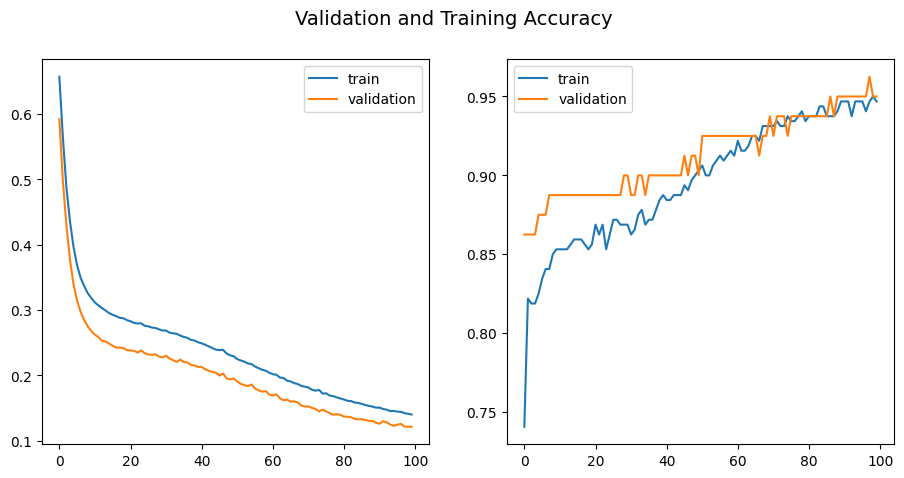

In [ ]:
# ---- graficamos la función de perdida ----
plt.figure(figsize=(11,5))
plt.subplot(1,2,1)
plt.suptitle("Validation and Training Loss",fontsize=14)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
# ---- graficamos la métrica de rendimiento ----
plt.subplot(1,2,2)
plt.suptitle("Validation and Training Accuracy",fontsize=14)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

### ➖ Leer el modelo y realizar predicciones con él

Leemos y evaluamos usando el modelo guardado del callback anterior.

**En esta parte, además, se muestra como evaluar *externamente* las métricas usuales de rendimiento.**

In [ ]:
from keras.models import load_model

model_reloaded = load_model(filepath)
y_pred = model_reloaded.predict(X_val)

In [ ]:
from sklearn.metrics import log_loss

print(f"Binary Cross Entropy: {log_loss(y_val,y_pred)}")

Observa la forma que tienen las predicciones, son probabilidades de pertenecer a la clase positiva (la clase 1). Recuerda que la última capa tiene una activación sigmoide que está en un rango $(0,1)$.

In [ ]:
print(y_pred.shape)
y_pred[:5]

Convirtamoslas a predicciones de clases para fin de evaluar también usando las métricas de rendimiento de clasificación de scikit-learn (precision, accuracy, etc).

In [ ]:
import numpy as np

y_pred_clases = np.where(y_pred>=0.5,1,0).flatten()
print(y_pred_clases.shape)
y_pred_clases[:5]

Ahora sí, podemos evaluar. Recordar que, para el `roc_auc_score` necesitamos las probabilidades de pertenecer a la clase.

In [ ]:
from sklearn.metrics import f1_score, precision_score, roc_auc_score

print(f"Precision Score: {precision_score(y_val,y_pred_clases)}")
print(f"Precision Score: {f1_score(y_val,y_pred_clases)}")
print(f"Precision Score: {roc_auc_score(y_val,y_pred)}")

También podemos recuperar la entropia binaria cruzada (la función de perdida) a partir del método `evaluate` del modelo.

In [ ]:
evaluation = model_reloaded.evaluate(X_val,y_val)

print(f"Validation loss and validation accuracy: {evaluation}")

# Dropout

Es fácil que las redes neuronales de aprendizaje profundo se sobreajusten rápidamente a un conjunto de datos de entrenamiento con pocos ejemplos.

Se sabe que los conjuntos de redes neuronales con diferentes configuraciones de modelos reducen el sobreajuste, pero requieren el gasto computacional adicional de entrenar y mantener múltiples modelos.

Se puede utilizar un único modelo para simular que se dispone de un gran número de arquitecturas de red diferentes mediante la eliminación aleatoria de nodos durante el entrenamiento. Esto se denomina *dropout* y ofrece un método de regularización muy barato desde el punto de vista computacional y notablemente eficaz para reducir el sobreajuste y mejorar el error de generalización en redes neuronales profundas de todo tipo.

**Esta estrategia no siempre mejora el rendimiento de la red y hay opiniones divididas en cuanto a su eficacia. Sin embargo, es una técnica clásica del deep learning.**

<img align="left" width="50%" src="../img/dropout.png"/>

Usaremos el dataset de [diabetes PIMA](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database) que usamos en el módulo pasado. Usamos este dataset por su tamaño pequeño.

En este ejercicio observaremos como el dropout puede ayudar a prevenir el overfitting, aunque no necesariamente mejore la pérdida.

In [ ]:
url = "https://raw.githubusercontent.com/DCDPUAEM/DCDP/main/03-Deep-Learning/data/diabetes.csv"
!wget --no-cache --backups=1 {url}

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('diabetes.csv',index_col=0)
df

In [ ]:
X = df.iloc[:,:8].values
y = df.iloc[:,8].values

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.875,random_state=89)

print(f"Train size: {X_train.shape[0]}")
print(f"Test size: {X_test.shape[0]}")

Escalaremos los datos para mejorar el rendimiento de la red. Esto, debido a la variedad en los rangos de las variables.

In [ ]:
df.describe()

In [ ]:
from sklearn.preprocessing import StandardScaler

scl = StandardScaler()
X_train = scl.fit_transform(X_train)
X_test = scl.transform(X_test)

## Sin dropout

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()

model.add(Dense(8, input_dim=8, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, validation_split=0.1, epochs=50,verbose=0)

In [ ]:
import matplotlib.pyplot as plt

# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train accuracy: %.3f. Test accuracy : %.3f' % (train_acc, test_acc))

# ---- graficamos la función de perdida ----
plt.figure(figsize=(11,5))
plt.subplot(1,2,1)
plt.suptitle("Validation and Training Loss",fontsize=14)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
# ---- graficamos la métrica de rendimiento ----
plt.subplot(1,2,2)
plt.suptitle("Validation and Training Accuracy",fontsize=14)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

## Usando dropout: Efecto en el overfitting

Usaremos la misma arquitectura general de la red. Añadimos dos capas de dropout, las tasas de dropout fueron seleccionadas con gridsearch.

In [ ]:
from tensorflow.keras.layers import Dropout

def build_model():
    model = Sequential()
    model.add(Dense(8, input_dim=8, activation='relu'))
    model.add(Dropout(0.663))
    model.add(Dense(15, activation='relu'))
    model.add(Dropout(0.518))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model_do = build_model()

In [ ]:
history = model_do.fit(X_train, y_train, validation_split=0.1, epochs=50,verbose=0)

In [ ]:
import matplotlib.pyplot as plt

# evaluate the model
_, train_acc = model_do.evaluate(X_train, y_train, verbose=0)
_, test_acc = model_do.evaluate(X_test, y_test, verbose=0)
print('Train accuracy: %.3f. Test accuracy : %.3f' % (train_acc, test_acc))

# ---- graficamos la función de perdida ----
plt.figure(figsize=(11,5))
plt.subplot(1,2,1)
plt.suptitle("Validation and Training Loss",fontsize=14)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
# ---- graficamos la métrica de rendimiento ----
plt.subplot(1,2,2)
plt.suptitle("Validation and Training Accuracy",fontsize=14)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

Aumentemos el número de épocas

In [ ]:
model_do_2 = build_model()

es = EarlyStopping(patience=3)

history = model_do_2.fit(X_train, y_train, validation_split=0.1, epochs=200,verbose=0,
                       callbacks=[es])

In [ ]:
# ---- evaluamos el modelo ----
_, train_acc = model_do_2.evaluate(X_train, y_train, verbose=0)
_, test_acc = model_do_2.evaluate(X_test, y_test, verbose=0)
print('Train accuracy: %.3f. Test accuracy : %.3f' % (train_acc, test_acc))

# ---- graficamos la función de perdida ----
plt.figure(figsize=(11,5))
plt.subplot(1,2,1)
plt.suptitle("Validation and Training Loss",fontsize=14)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
# ---- graficamos la métrica de rendimiento ----
plt.subplot(1,2,2)
plt.suptitle("Validation and Training Accuracy",fontsize=14)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

# Gridsearch

A continuación se muestra cómo realizar un gridsearch para obtener los mejores parámetros de una red neuronal, es decir, los que producen las mejores métricas. Estos parámetros pueden ser el número de neuronas, la tasa de dropout, las épocas, etc.

Para poder usar el gridsearch de scikit-learn es necesario *traducir* el módelo de red neuronal a un clasificador de scikit-learn. Esto lo hacemos con la clase `KerasClassifier`.

**❗Warning**: Si se especifican un gran número de parámetros en la busqueda, esta puede tardar mucho y pueden ser penalizados en el uso de GPU en Colab. Usar con cuidado.

Usaremos el dataset de [diabetes](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database) que usamos en el módulo pasado. Usamos este dataset por su tamaño pequeño.

In [ ]:
import numpy as np
import pandas as pd

df = pd.read_csv("diabetes.csv", index_col=0)
df

Extraemos del dataframe la matriz de features y el vector de clases. En este caso es una clasificación binaria.

In [ ]:
X = df.iloc[:,:8].values
Y = df.iloc[:,8].values

Es necesario crear una función que cree el modelo, esta debe depender de los parámetros sobre los que se quiere realizar la busqueda. Es necesario crear el modelo, compilarlo y regresarlo ya compilado.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense


def create_model(n_neurons,activation):
	model = Sequential()
	model.add(Dense(n_neurons, input_dim=8, activation=activation))
	model.add(Dense(1, activation='sigmoid'))
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

Creamos un modelo de clasificador de scikit-learn usando la API de Keras. Esta empaqueta el módelo de keras como un estimador de scikit-learn.

[Documentación](https://adriangb.com/scikeras/stable/quickstart.html#training-a-model)

In [ ]:
!pip install scikeras[tensorflow]

In [ ]:
from scikeras.wrappers import KerasClassifier

es = EarlyStopping(monitor='val_loss',patience=2)

model = KerasClassifier(
    create_model,
    n_neurons=12,
    activation='sigmoid',
    epochs=50,
    verbose=0,
    callbacks=[es],
    validation_split=0.15
)

Realizamos la busqueda de parámetros

In [ ]:
from sklearn.model_selection import GridSearchCV

# ----- Definimos los parámetros de la busqueda -----
neurons = [5,10,20,50]
activations = ['relu','sigmoid','tanh']
param_grid = {'n_neurons':neurons,
              'activation':activations}

# ----- Definimos y realizamos el gridsearch
gs = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = gs.fit(X, Y)

Veamos los mejores parámetros

In [ ]:
print(f"Best Accuracy: {grid_result.best_score_} using parameters {grid_result.best_params_}")

Podemos acceder al mejor modelo y usarlo.

**Observación**:  El modelo, aún cuando es una red neuronal, está presentado como un estimador de scikit-learn por lo que no tiene método `evaluate` (este es de keras), sino `score` (este es de sklearn).

In [ ]:
best_model = gs.best_estimator_

best_model.score(X_test,y_test)

## ⭕ Práctica 1

En esta práctica haremos regresión multi-output usando el dataset `mo_regression.csv` de la carpeta data del módulo en el repositorio.

0. Divide el conjunto de datos en 80% entrenamiento y 20% prueba.
1. Define una *primer* red neuronal MLP para resolver esta tarea. La función de perdida a usar será 'MSE'.
2. Prueba diferentes combinaciones de hiperparámetros para encontrar el mejor modelo que puedas en cuanto a desempeño en el conjunto de prueba, usando la métrica MAE.